### Import library

In [1]:
import numpy as np
import pandas as pd
import warnings
import os
import random
import pickle
# import ML related libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from bayes_opt import BayesianOptimization
# import plotting related libraries
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy import interpolate
from keras.layers import LeakyReLU

In [2]:
#SetUp
datapathway=r"C:\Users\wingt\OneDrive\Desktop\DataForIPML\dataset_1a_db2.csv"
input_column_list=[1,2,3,4,5]
output_column_list=[6] #column of ystart
yname='Thermo-couple'      # name of the ultimate output array (HSCP value)
yparameter='Near or Far'       #position here but it will be what is the parameter to be tuned (HSCP_name)
xcolumn=['heat', 'speed', 'ra','rl','rv'] #name of inputs
ycolumn=['Near Field Thermo-Couple'] #name of outputs (HSCP_name)
optimizer_search_list=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation_list1=['relu',LeakyReLU(alpha=0.3),'hard_sigmoid','elu','sigmoid','softmax']
train_test_split_test_size=0.2
validation_split=0.1

### Get Plot
It is a function plotting the actual simulation result and the prediction result

In [3]:
def get_plot(oringin_data, predict_data, i):
    '''
    Plot target outputs against predicted outputs
    inputs:
        oringin_data: target outputs
        predict_data: predicted outputs
        i: plot index
        root: root for saving figure
    '''
    root = r'ANN_results/BD/test/test--' + str(i) + '.jpg'
    fig, ax = plt.subplots(figsize=(10,6))
    x = y_label_new
    oringin_data = oringin_data 
    predict_data = predict_data 
    p1 = ax.plot(x,oringin_data.ravel(),'r--', label = 'Target stress')
    p2 = ax.plot(x,predict_data.ravel(),'g--',label = 'Predict stress')
    ax.set_title("Test-Set" + str(i))
    # ax.set_xticks(x)
    ax.set_ylabel('Logitudinal stress (MPa)')
    ax.set_xlabel('Distance from top surface Z(mm)')
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_tick_params(direction='out')

    ax2 = plt.twinx()
    difference = predict_data.ravel() - oringin_data.ravel()
    difference=np.array(list(map(lambda x,y:x/y,difference,oringin_data.ravel())))


    legend_elements = [Line2D([0], [0], color='red', lw=2, label='Simulation result'),
                       Line2D([0], [0], color='green', lw=2, label='ANN prediction')
                      ]

    ax.legend(handles=legend_elements, loc='best')
    plt.savefig(root)
    plt.close()

### Function of tuning activation function

### Optimizer and activation function tuning function
a function to tune the hyperparameter of the ANN machine-> optimizer
model used is from KerasRegressor
Used gridsearch cross validation
printing the best optimizer name and the score of this machine
printing the mean_test_score, std_test_score, parameter for all the optimizer tested

### function for creating a model for tuning optimiser

### Neural Network training function for Bayesian Optimisation
use a function for defning the machine name and parameters for the machine
use KerasRegressor to build the machine with specified hyperparameters
use processed training input and output (will define function to make them later) for training the model
history is the name of the model
return a scoe showing cross validation mse

### Other hyperparameters tuning function
a function tuning the other hyperparameter, including number of hidden nodes, learning rate, batch size,
set number of epochs to 1000
still use GridSearch CV and print the same thing as step 3

### function for creating a model for tuning other hyper parameter

### Plot_history
plot learning curve
make learning history(generated later after building a model) a dataframe and insert a column called epoch in it
plot MSE against epoch
plot val_mse (should be validation mse) against no of epoch (validation error)

In [4]:
def plot_history(history):
    '''
    Plot learning curve using NN training history info
    '''
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(12,12))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Mean Square Error [$MPG^2$]',fontsize=20)
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')

    plt.ylim([0,10*10**-4])
    plt.legend()
    plt.show()

### import data + preprocessing(select the suitable columns)
import the data using pd.read_csv
only get columns required
assign column names
get y data for training as well

In [5]:
def data_import(csv_file_name,input_column_list,output_column_list):
    '''
    used to import dataset and split training and test dataset
    csv_file_name is the dateset root
    reture traing and test datasets
    '''
    raw_data = pd.read_csv(csv_file_name,header=None).dropna()
    x = raw_data.iloc[:,input_column_list].astype(float)
    y = raw_data.iloc[:,output_column_list].astype(float)
    return x, y

### function for creating a model for all tuned hyperparameter(actual model)

### assign column names to data set 
can see only one column of y here

In [6]:
def data_melt(x, y,xcolumn,ycolumn,yparameter,yname):
    '''
    Add position as input
    input:
        x: old input 
        y: old output
    output:
        x_new: new input 
        y_new: new output
    '''
    y_label_str = [str(x) for x in ycolumn] # make a list of string of y_label_new
    dataset = pd.concat([x, y],axis=1, ignore_index=True)
    col_names = xcolumn + y_label_str
    dataset.columns = col_names
    dataset = dataset.melt(id_vars=xcolumn, 
        var_name=yparameter, 
        value_name=yname) #for given case, select which HSP to be found
    x_new = dataset.iloc[:, 0:(len(xcolumn)+1)]
    y_new = dataset.iloc[:, (len(xcolumn)+1)]
    print('DATASET')
    print(dataset)
    return x_new, y_new

### define mean square error function MSE

In [7]:
def MSE(testY, predicY):
    '''
    Get MSE fun
    '''
    MSE=np.sum(np.power((testY - predicY),2))/testY.shape[1]/testY.shape[0]
    return MSE

### Define a function getting number of output

In [8]:
def get_N_output(Y_train):
    '''
    Get the number of outputs
    '''
    if Y_train.ndim == 1:
        N_outputs = 1
    else:
        N_outputs = Y_train.shape[1]
    return N_outputs

### Prepocessing function

In [25]:
def pre_processing(model_type, x, y,train_test_split_test_size,xcolumn,ycolumn,yparameter,yname):
    '''
    Data preprocessing (Uniformly spaced sampling, normalisation, train test split)
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)        
        x: a dataframe of inputs of the whole dataset
        y: a dataframe of outputs of the whole dataset
    outputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        Y_test: Test output
    '''
    # Split dataset
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=train_test_split_test_size, random_state=3)
    X_train=pd.DataFrame(X_train[:].values)
    X_test =pd.DataFrame(X_test[:].values)
    Y_train=pd.DataFrame(Y_train[:].values)
    Y_test=pd.DataFrame(Y_test[:].values)
    # data reconstruction
    if 'ANN2' in model_type:
        X_train, Y_train = data_melt(X_train, Y_train,xcolumn,ycolumn,yparameter,yname)
        X_test, Y_test_1 = data_melt(X_test, Y_test,xcolumn,ycolumn,yparameter,yname)

    # Normalization
    global scaler_X, scaler_Y
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    scaled_train_X = scaler_X.fit_transform(X_train.to_numpy())
    scaled_test_X = scaler_X.transform(X_test)

    if Y_train.ndim == 1:
      Y_train = np.array(Y_train).reshape(-1,1)#column array
    scaled_train_Y = scaler_Y.fit_transform(Y_train)
    Proc_X_train = scaled_train_X
    Proc_Y_train = scaled_train_Y
    Proc_X_test = scaled_test_X

    return model_type, Proc_X_train, Proc_Y_train, Proc_X_test, Y_test

### Get Result function
build a model based on preprocessed data and tuned hyperparameter
output the model, predicted scalar transformed y, predicted y in 21 columns, history of fitting

### fix random seed

In [10]:
def seed_tensorflow(seed):
    '''
    Fix ramdom seed
    '''
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)

### actual import and train test split


### Optimizer and activation function Tuning

In [11]:
def tune_optimizer_ACT(optimizer_search_list,activation_list1,optimizer_tuning_number_of_full_update=200,
                       optimizer_tuning_number_sample_used_in_one_training=10):
    # callbacks = [
    #     EarlyStopping(monitor='mse', patience=100, verbose=0),
    # ]
    model = KerasRegressor(build_fn=create_model, nb_epoch=optimizer_tuning_number_of_full_update, batch_size=optimizer_tuning_number_sample_used_in_one_training, verbose=0) 
    optimizer = optimizer_search_list # 200 hidden nodes
    param_grid = dict(optimizer=optimizer,activation1=activation_list1) 
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,verbose=10)
    grid_result = grid.fit(Proc_X_train, Proc_Y_train)
    global BEST_ACT_1,BEST_OPT
    BEST_ACT_1=grid.best_params_['activation1']
    BEST_OPT=grid.best_params_['optimizer']
    print('tuned activation function for hidden layer:')
    print('BEST_ACT_1:',BEST_ACT_1)
    print('tuned optimizer')
    print('BEST_OPT:',BEST_OPT)

In [12]:
def create_model(optimizer='adam',activation1='relu'):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(200, activation=activation1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    model.summary()
    return model

### function of tuning other parameter (timed)

In [66]:
def get_hype_T_dict(BEST_OPT,BEST_ACT_1,optimizer_search_list):
    SGD_TD= {'momentum':[0,0.2,0.4,0.6,0.8],
         'nesterov':[True,False]}
    RMSprop_TD={'rho':[0.001,0.01,0.1,0.5,0.9],
            'momentum':[0,0.2,0.4,0.6,0.8],
            'epsilon':[1e-9,1e-8,1e-7,1e-6,1e-5]}
    Adagrad_TD={'initial_accumulator_value':[0.001,0.01,0.1,0.5,0.9],
            'epsilon':[1e-9,1e-8,1e-7,1e-6,1e-5]}
    Adadelta_TD={'rho':[0.001,0.01,0.1,0.5,0.9],
             'epsilon':[1e-9,1e-8,1e-7,1e-6,1e-5]}
    Adam_TD={'beta_1':[0.001,0.01,0.1,0.5,0.9],
         'beta_2':[0.001,0.01,0.1,0.5,0.9,0.99,0.999],
         'epsilon':[1e-9,1e-8,1e-7,1e-6,1e-5]}
    Adamax_TD=Adam_TD
    Nadam_TD=Adam_TD
    TD=[SGD_TD,RMSprop_TD,Adagrad_TD,Adadelta_TD,Adam_TD,Adamax_TD,Nadam_TD]
    hype_search_dict={'learning_rate':[0.001,0.01,0.1,0.2],
                      'N_hidden_nodes':[100,500,1000,1500,2000],
                      'batch_size':[1,8,16,31], 
                      'nb_epoch':[1000,2000,3000],
                     'BEST_ACT_1':[BEST_ACT_1]}
    for i, opt in enumerate(optimizer_search_list):
        if BEST_OPT==opt:
            hype_search_dict.update(TD[i])
    return hype_search_dict

In [67]:
def create_model_2_SGD(N_hidden_nodes,learning_rate,momentum, nesterov,BEST_ACT_1):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                optimizer=keras.optimizers.SGD(learning_rate=learning_rate,momentum=momentum,nesterov=nesterov),
                metrics=['mse'])
    model.summary()
    return model

def create_model_2_RMSprop(N_hidden_nodes,learning_rate,rho,momentum, epsilon,BEST_ACT_1):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate,rho=rho,momentum=momentum,epsilon=epsilon),
                metrics=['mse'])
    model.summary()
    return model
    
def create_model_2_Adagrad(N_hidden_nodes,learning_rate,initial_accumulator_value, epsilon,BEST_ACT_1):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate,initial_accumulator_value=initial_accumulator_value,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    return model

def create_model_2_Adadelta(N_hidden_nodes,learning_rate,rho, epsilon,BEST_ACT_1):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adadelta(learning_rate=learning_rate,rho=rho,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    return model
def create_model_2_Adam(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,BEST_ACT_1):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=Keras.optimizers.Adam(learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    return model
def create_model_2_Adamax(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,BEST_ACT_1):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adamax(learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    return model
def create_model_2_Nadam(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,BEST_ACT_1):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Nadam(learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    return model

In [68]:
def tune_other_para(BEST_OPT,BEST_ACT_1,optimizer_search_list):
    if BEST_OPT=='SGD':
        model = KerasRegressor(build_fn=create_model_2_SGD,verbose=2)
    if BEST_OPT=='RMSprop':
        model = KerasRegressor(build_fn=create_model_2_RMSprop,verbose=2)
    if BEST_OPT=='Adagrad':
        model = KerasRegressor(build_fn=create_model_2_Adagrad,verbose=2)
    if BEST_OPT=='Adadelta':
        model = KerasRegressor(build_fn=create_model_2_Adadelta,verbose=2)
    if BEST_OPT=='Adam':
        model = KerasRegressor(build_fn=create_model_2_Adam,verbose=2)
    if BEST_OPT=='Adamax':
        model = KerasRegressor(build_fn=create_model_2_Adamax,verbose=2)
    if BEST_OPT=='Nadam':
        model = KerasRegressor(build_fn=create_model_2_Nadam,verbose=2)
    param_grid = get_hype_T_dict(BEST_OPT,BEST_ACT_1,optimizer_search_list)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=10,verbose=3)
    grid_result = grid.fit(Proc_X_train, Proc_Y_train)
    global OTHERTUNEDDICT
    OTHERTUNEDDICT=grid.best_params_
    print('tuned hyperparameters:')
    B_N_hidden_nodes=grid.best_params_['N_hidden_nodes']
    B_learning_rate=grid.best_params_['learning_rate']
    B_Batch_size=grid.best_params_['batch_size']
    B_epochs=grid.best_params_['nb_epoch']
    print('B_N_hidden_nodes:',B_N_hidden_nodes)
    print('B_learning_rate:',B_learning_rate)
    print('B_Batch_size:',B_Batch_size)
    print('B_epochs:',B_epochs)
    if BEST_OPT=='SGD':
        B_momentum_SGD=grid.best_params_['momentum']
        B_nesterov_SGD=grid.best_params_['nesterov']
        print('B_momentum_SGD:',B_momentum_SGD)
        print('B_nesterov_SGD:',B_nesterov_SGD)
    if BEST_OPT=='RMSprop':
        B_rho_RMSprop=grid.best_params_['rho']
        B_momentum_RMSprop=grid.best_params_['momentum']
        B_epsilon_RMSprop=grid.best_params_['epsilon']
        print('B_rho_RMSprop:',B_rho_RMSprop)
        print('B_momentum_RMSprop:',B_momentum_RMSprop)
        print('B_epsilon_RMSprop:',B_epsilon_RMSprop)
    if BEST_OPT=='Adagrad':
        B_initial_accumulator_value_Adagrad=grid.best_params_['initial_accumulator_value']
        B_epsilon_Adagrad=grid.best_params_['epsilon']
        print('B_initial_accumulator_value_Adagrad:',B_initial_accumulator_value_Adagrad)
        print('B_epsilon_Adagrad:',B_epsilon_Adagrad)
    if BEST_OPT=='Adadelta':
        B_rho_Adadelta=grid.best_params_['rho']
        B_epsilon_Adadelta=grid.best_params_['epsilon']
        print('B_rho_Adadelta:',B_rho_Adadelta)
        print('B_epsilon_Adadelta:',B_epsilon_Adadelta)
    if BEST_OPT =='Adam':
        B_beta_1_Adam=grid.best_params_['beta_1']
        B_beta_2_Adam=grid.best_params_['beta_2']
        B_epsilon_Adam=grid.best_params_['epsilon']
        print('B_beta_1_Adam:',B_beta_1_Adam)
        print('B_beta_2_Adam:',B_beta_2_Adam)
        print('B_epsilon_Adam:',B_epsilon_Adam)
    if BEST_OPT =='Adamax':
        B_beta_1_Adamax=grid.best_params_['beta_1']
        B_beta_2_Adamax=grid.best_params_['beta_2']
        B_epsilon_Adamax=grid.best_params_['epsilon']
        print('B_beta_1_Adamax:',B_beta_1_Adamax)
        print('B_beta_2_Adamax:',B_beta_2_Adamax)
        print('B_epsilon_Adamax:',B_epsilon_Adamax)
    if BEST_OPT =='Nadam':
        B_beta_1_Nadam=grid.best_params_['beta_1']
        B_beta_2_Nadam=grid.best_params_['beta_2']
        B_epsilon_Nadam=grid.best_params_['epsilon']
        print('B_beta_1_Nadam:',B_beta_1_Nadam)
        print('B_beta_2_Nadam:',B_beta_2_Nadam)
        print('B_epsilon_Nadam:',B_epsilon_Nadam)

In [16]:
def build_model_SGD(N_hidden_nodes,learning_rate,momentum, nesterov,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0)
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                optimizer=keras.optimizers.SGD(learning_rate=learning_rate,momentum=momentum,nesterov=nesterov),
                metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=validation_split, callbacks=callbacks)
    return model, history
    
def build_model_RMSprop(N_hidden_nodes,learning_rate,rho,momentum,epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0)
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate,rho=rho,momentum=momentum,epsilon=epsilon),
                metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=validation_split, callbacks=callbacks)
    return model, history
def build_model_Adagrad(N_hidden_nodes,learning_rate,initial_accumulator_value, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0)
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate,initial_accumulator_value=initial_accumulator_value,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=validation_split, callbacks=callbacks)
    return model, history
def build_model_Adadelta(N_hidden_nodes,learning_rate,rho, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0)
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adadelta(learning_rate=learning_rate,rho=rho,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=validation_split, callbacks=callbacks)
    return model, history
def build_model_Adam(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0)
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=Keras.optimizers.Adam(learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=validation_split, callbacks=callbacks)
    return model, history
def build_model_Adamax(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0)
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=Keras.optimizers.Adamax(learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=validation_split, callbacks=callbacks)
    return model, history
def build_model_NAdam(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0)
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=BEST_ACT_1, input_shape=(Proc_X_train.shape[1],)),
        keras.layers.Dense(get_N_output(Proc_Y_train),activation='linear')
    ])
    model.compile(loss='mse',
                  optimizer=Keras.optimizers.Nadam(learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon),
                  metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=validation_split, callbacks=callbacks)
    return model, history

In [17]:
def get_result_SGD(model_type, Proc_X_train, Proc_Y_train, Proc_X_test, N_hidden_nodes,learning_rate,momentum, nesterov,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    model, history = build_model_SGD(N_hidden_nodes,learning_rate,momentum, nesterov,Batch_size, Epochs,BEST_ACT_1,validation_split)
    # Predict
    
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (get_N_output(Y_test), -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history


def get_result_RMSprop(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,rho,momentum, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    model, history = build_model_RMSprop(N_hidden_nodes,learning_rate,rho,momentum, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    # Predict
    
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (get_N_output(Y_test), -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history

def get_result_Adagrad(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,initial_accumulator_value, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    model, history = build_model_Adagrad(N_hidden_nodes,learning_rate,initial_accumulator_value, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    # Predict
    
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (get_N_output(Y_test), -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history

def get_result_Adadelta(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,rho, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    model, history = build_model_Adadelta(N_hidden_nodes,learning_rate,rho, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    # Predict
    
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (get_N_output(Y_test), -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history

def get_result_Adam(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    model, history = build_model_Adam(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    # Predict
    
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (get_N_output(Y_test), -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history

def get_result_Adamax(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    model, history = build_model_Adamax(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    # Predict
    
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (get_N_output(Y_test), -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history

def get_result_NAdam(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    model, history = build_model_NAdam(N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    # Predict
    
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (get_N_output(Y_test), -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history

In [76]:
def ActualTraining(OTHERTUNEDDICT,BEST_OPT,BEST_ACT_1,validation_split):
    print('INFORMATION:')
    print('Used otpimizer:',BEST_OPT)
    print('Used hidden nodes activation function:',BEST_ACT_1)
    D=OTHERTUNEDDICT
    N_hidden_nodes=D['N_hidden_nodes']
    learning_rate=D['learning_rate']
    Batch_size=D['batch_size']
    Epochs=D['nb_epoch']
    print('Used N_hidden_nodes:',N_hidden_nodes)
    print('Used learning_rate:',learning_rate)
    print('Used Batch_size:',Batch_size)
    print('Used Epochs:',Epochs)
    if BEST_OPT=='SGD':
        momentum=D['momentum']
        nesterov=D['nesterov']
        print('Used momentum:',momentum)
        print('Used nesterov:',nesterov)
        ANN, predict_test_scal,predict_test, history = get_result_SGD(model_type, Proc_X_train, Proc_Y_train, Proc_X_test, N_hidden_nodes,learning_rate,momentum, nesterov,Batch_size, Epochs,BEST_ACT_1,validation_split)
    if BEST_OPT=='RMSprop':
        rho=D['rho']
        momentum=D['momentum']
        epsilon=D['epsilon']
        print('Used rho:',rho)
        print('Used momentum:',momentum)
        print('Used epsilon:',epsilon)
        ANN, predict_test_scal,predict_test, history =get_result_RMSprop(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,rho,momentum, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    if BEST_OPT=='Adagrad':
        initial_accumulator_value=D['initial_accumulator_value']
        epsilon=D['epsilon']
        print('Used initial_accumulator_value:',initial_accumulator_value)
        print('Used epsilon:',epsilon)
        ANN, predict_test_scal,predict_test, history =get_result_Adagrad(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,initial_accumulator_value, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    if BEST_OPT=='Adadelta':
        rho=D['rho']
        epsilon=D['epsilon']
        print('Used rho:',rho)
        print('Used epsilon:',epsilon)
        ANN, predict_test_scal,predict_test, history =get_result_Adadelta(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,rho, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    if BEST_OPT=='Adam':
        beta_1=D['beta_1']
        beta_2=D['beta_2']
        epsilon=D['epsilon']
        print('Used beta_1:',beta_1)
        print('Used beta_2:',beta_2)
        print('Used epsilon:',epsilon)
        ANN, predict_test_scal,predict_test, history =get_result_Adam(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    if BEST_OPT=='Adamax':
        beta_1=D['beta_1']
        beta_2=D['beta_2']
        epsilon=D['epsilon']
        print('Used beta_1:',beta_1)
        print('Used beta_2:',beta_2)
        print('Used epsilon:',epsilon)
        ANN, predict_test_scal,predict_test, history =get_result_Adamax(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    if BEST_OPT=='Nadam':
        beta_1=D['beta_1']
        beta_2=D['beta_2']
        epsilon=D['epsilon']
        print('Used beta_1:',beta_1)
        print('Used beta_2:',beta_2)
        print('Used epsilon:',epsilon)
        ANN, predict_test_scal,predict_test, history =get_result_NAdam(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,N_hidden_nodes,learning_rate,beta_1,beta_2, epsilon,Batch_size, Epochs,BEST_ACT_1,validation_split)
    return ANN, predict_test_scal,predict_test, history

### The actual implementation

In [20]:
#SetUp
datapathway=r"C:\Users\wingt\OneDrive\Desktop\DataForIPML\dataset_1a_db2.csv"
input_column_list=[1,2,3,4,5]
output_column_list=[6] #column of ystart
yname='Thermo-couple'      # name of the ultimate output array (HSCP value)
yparameter='Near or Far'       #position here but it will be what is the parameter to be tuned (HSCP_name)
xcolumn=['heat', 'speed', 'ra','rl','rv'] #name of inputs
ycolumn=['Near Field Thermo-Couple'] #name of outputs (HSCP_name)
optimizer_search_list=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation_list1=['relu',LeakyReLU(alpha=0.3),'hard_sigmoid','elu','sigmoid','softmax']
train_test_split_test_size=0.2
validation_split=0.1

In [28]:
# Fix ramdom seed
warnings.filterwarnings('ignore')
seed_tensorflow(42)
# Import dataset
x,y=data_import(datapathway,input_column_list,output_column_list)
# Pre-processing
model_type, Proc_X_train, Proc_Y_train, Proc_X_test, Y_test = pre_processing('ANN1', x, y,train_test_split_test_size,xcolumn,ycolumn,yparameter,yname)
#Tuning
OPT_ACT=tune_optimizer_ACT(optimizer_search_list,activation_list1,
                           optimizer_tuning_number_of_full_update=200,
                       optimizer_tuning_number_sample_used_in_one_training=10)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               1200      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
tuned activation function for hidden layer:
BEST_ACT_1: elu
tuned optimizer
BEST_OPT: SGD


In [70]:
tune_other_para(BEST_OPT=BEST_OPT,BEST_ACT_1=BEST_ACT_1, optimizer_search_list=optimizer_search_list)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________
583/583 - 0s - loss: 0.0918 - mse: 0.0918
tuned hyperparameters:
B_N_hidden_nodes: 100
B_learning_rate: 0.001
B_Batch_size: 1
B_epochs: 1000
B_momentum_SGD: 0
B_nesterov_SGD: True


In [77]:
#Actual Model Training
ANN, predict_test_scal,predict_test, history=ActualTraining(OTHERTUNEDDICT=OTHERTUNEDDICT,BEST_OPT=BEST_OPT,BEST_ACT_1=BEST_ACT_1,validation_split=validation_split)

INFORMATION:
Used otpimizer: SGD
Used hidden nodes activation function: elu
Used N_hidden_nodes: 100
Used learning_rate: 0.001
Used Batch_size: 1
Used Epochs: 1000
Used momentum: 0
Used nesterov: True
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
524/524 [==============================] - 0s 621us/step - loss: 0.1464 - mse: 0.1464 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 2/1000
524/524 [==============================] - 0s 602us/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 3/1000
524/524 [=======================

### Validation

0.0003230120997722503
0.8967045933082268


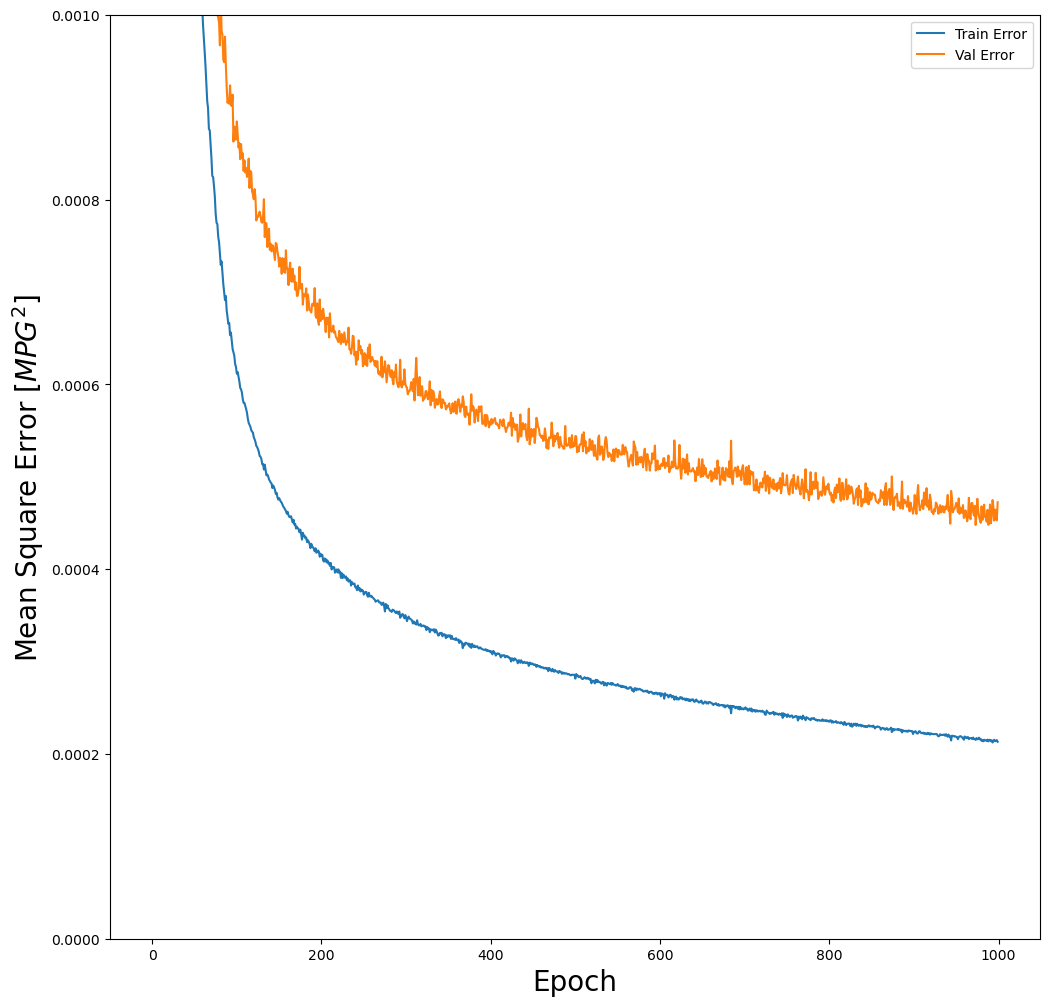

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


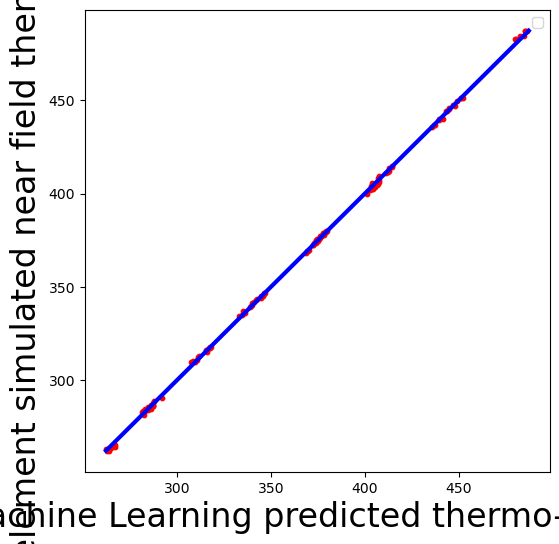

In [78]:
Y_test_scal = scaler_Y.transform(Y_test.values.reshape(-1,1)).reshape(-1, get_N_output(Y_test))
MSE_R_scal = MSE(Y_test_scal, predict_test_scal)
MSE_R = MSE(Y_test.values, predict_test)
print(MSE_R_scal)
print(MSE_R)
plot_history(history)
# save the model
# ANN.save(r'data_analysis/saved_model/ANN.h5')
# pickle.dump(scaler_X, open('scaler_X.pkl','wb'))
# pickle.dump(scaler_Y, open('scaler_Y.pkl','wb'))

#for i in range(len(predict_test)):
#get_plot(Y_test.iloc[i, :], predict_test[i], i)

pred_results = []
sim_results = []
for i in range(len(predict_test)):
    for j in range(len(predict_test[0])):
        sim_results.append(Y_test.iloc[i, j])
        pred_results.append(predict_test[i][j])

max_results = max(max(pred_results,sim_results))
min_results = min(min(pred_results,sim_results))
fig,ax = plt.subplots(figsize=(6,6))
ax.plot([min_results, max_results], [min_results, max_results],'b', linewidth=3)
ax.scatter(pred_results, sim_results,s=10, c='r')
ax.set_xlabel("Machine Learning predicted thermo-couple", fontsize=24)
ax.set_ylabel("Finite element simulated near field thermo-couple", fontsize=24)
plt.legend()
plt.show()

In [ ]:
print(MSE_R_scal)
print(MSE_R)